# Notebook imports

In [3]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from PIL import Image

%matplotlib inline

# Constants

In [4]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH =  'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH =  'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH =  'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH =  'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'
SPAM_CAT = 1
HAM_CAT = 0
DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'

# Reading Files

In [5]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

#print(message)

In [6]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [7]:
# Read only the body of message
stream = open(EXAMPLE_FILE, encoding='latin-1')
is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
    
stream.close()
email_body = '\n'.join(lines)

#print(email_body)


# Generator Functions

In [8]:
def generate_square(N):
    for my_number in range (N):
        yield my_number**2

In [9]:
for i in generate_square(3):
    print(i, end='->')


0->1->4->

## Email body extraction

In [10]:
def email_body_generator(path):
    for root, dirname, filenames in walk(path):
        for file_name in filenames:

            filepath = join(root, file_name) 
            
            # Read only the body of message
            stream = open(filepath, encoding='latin-1')
            is_body = False
            lines = []
            #skip until find the first '\n' * start of body message *
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
                
            stream.close()
            # convert the list of lines in one big string
            email_body = '\n'.join(lines)
            #Return the file name and body of message
            yield file_name, email_body


In [11]:
def df_from_directory(path, classification):
    rows = []
    rows_names = []

    for file_name, email_body in email_body_generator(path):
        # create a list of dictionary
        rows.append({'MESSAGE' : email_body, 'CATEGORY': classification })
        # create a list with files names (will be the index)
        rows_names.append(file_name)

    return pd.DataFrame(rows, index=rows_names)

In [12]:
# Create a DataFrame with analyses for each file in a directory path
# All files are know that contains SPAMs
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)

# Append the second dataframe of SPAMs
spam_emails = pd.concat([spam_emails, df_from_directory(SPAM_2_PATH, SPAM_CAT)])

spam_emails.head()

,MESSAGE,CATEGORY
00243.c6e70273fe1cf9e56e26bb6bbeef415d,\n\n\n\n ************...,1
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1


In [13]:
spam_emails.shape

(1898, 2)

In [14]:
# Chalenge: create a dataframe with all non-spam e-mails
# Create a DataFrame with analyses for each file in a directory path
# All files are know that contains SPAMs
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)

# Append the second dataframe of SPAMs
ham_emails = pd.concat([ham_emails, df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)])

ham_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [15]:
ham_emails.shape

(3901, 2)

In [16]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00243.c6e70273fe1cf9e56e26bb6bbeef415d,\n\n\n\n ************...,1
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1


In [17]:
data.tail()

,MESSAGE,CATEGORY
00358.87ee38040ac1f42320c7b89628b1850a,Quoting Paul Linehan (plinehan@yahoo.com):\n\n...,0
00359.29dd3e8213e61044d67bc15a6f9a5231,Rick Moen <rick@linuxmafia.com> wrote:\n\n\n\n...,0
00360.fb2dbe3d751033f3e7b125b20ecdb897,\n\nRick Moen <rick@linuxmafia.com> a écrit:\n...,0
00361.ebcde1d624e84623713ac6eddff87943,"On Tue, Aug 13, 2002 at 01:40:21AM +0200, Paul...",0
00362.10247e6e4b5d711a09d7d81c58dcf97c,"On Mon, Aug 12, 2002 at 08:05:58PM +0100, Nick...",0


# Data Cleaning: checking for missing values

In [18]:
# check if any message body is null
data['MESSAGE'].isnull().values.any()

np.False_

In [19]:
# Check if are any empty e-mail
(data['MESSAGE'].str.len() == 0).any()

np.True_

In [20]:
# Count if are any empty e-mail
(data['MESSAGE'].str.len() == 0).sum()

np.int64(3)

In [21]:
# Chalenge: how to count how many null values
data['MESSAGE'].isnull().sum()

np.int64(0)

### Locate empty emails

In [22]:
type(data['MESSAGE'].str.len() == 0)

pandas.core.series.Series

In [23]:
data[data['MESSAGE'].str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [24]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False], shape=(5799,))

# Remove System file entries on Dataframe

In [25]:
data.drop(['cmds'], inplace=True)

In [26]:
# sanity check
(data['MESSAGE'].str.len() == 0).sum()
data.shape

(5796, 2)

# Add document ID to track Emails in Dataset

In [27]:
document_ids =range (0, len(data.index))
document_ids

# create the column
data['DOC_ID'] = document_ids

# preserve the file_name colum and add new index
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()


,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,\n\n\n\n ************...,1,00243.c6e70273fe1cf9e56e26bb6bbeef415d
1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
3,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
4,##############################################...,1,00004.eac8de8d759b7e74154f142194282724


In [28]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,Quoting Paul Linehan (plinehan@yahoo.com):\n\n...,0,00358.87ee38040ac1f42320c7b89628b1850a
5792,Rick Moen <rick@linuxmafia.com> wrote:\n\n\n\n...,0,00359.29dd3e8213e61044d67bc15a6f9a5231
5793,\n\nRick Moen <rick@linuxmafia.com> a écrit:\n...,0,00360.fb2dbe3d751033f3e7b125b20ecdb897
5794,"On Tue, Aug 13, 2002 at 01:40:21AM +0200, Paul...",0,00361.ebcde1d624e84623713ac6eddff87943
5795,"On Mon, Aug 12, 2002 at 08:05:58PM +0100, Nick...",0,00362.10247e6e4b5d711a09d7d81c58dcf97c


# Save to file using Pandas

In [29]:
data.to_json(DATA_JSON_FILE)

# Number of spam messages Visualised (Pie chart)

In [30]:
data['CATEGORY'].value_counts()

CATEGORY
0    3900
1    1896
Name: count, dtype: int64

In [31]:
amount_of_spam = data['CATEGORY'].value_counts()[1]
amount_of_ham = data['CATEGORY'].value_counts()[0]

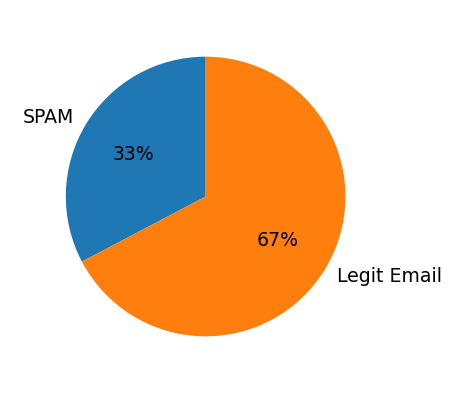

In [32]:
category_names = ['SPAM', 'Legit Email']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%')
plt.show()

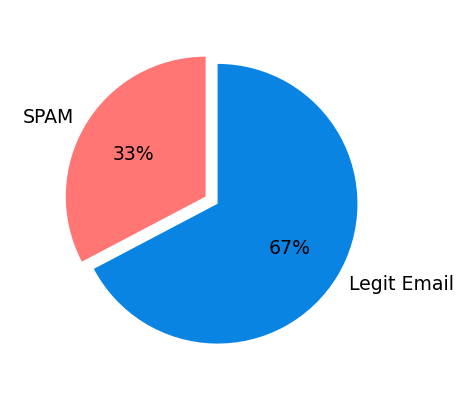

In [33]:
category_names = ['SPAM', 'Legit Email']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675', '#0984e3']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%',
        colors=custom_colors, explode=[0, 0.1])
plt.show()

# Donut chart (lesson 104)

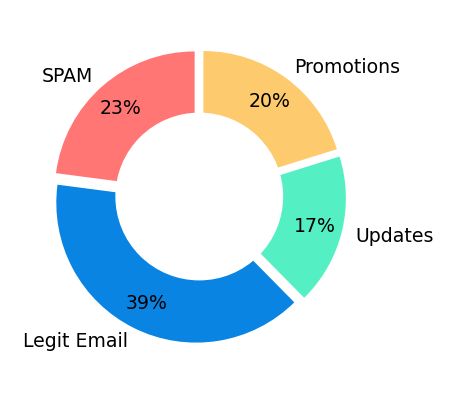

In [34]:
category_names = ['SPAM', 'Legit Email', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colors = ['#ff7675', '#0984e3', '#55efc4', '#fdcb6e']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%',
        colors=custom_colors, pctdistance=0.8, explode=offset)

# draw a white circle inside
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

### Text Pre-processing

In [35]:
msg = 'All work and no play makes Jake a dull boy.'
msg.lower()

'all work and no play makes jake a dull boy.'

### Download the NLTK Resources (Tokenizer and Stopwords) 

In [36]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jleitao/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jleitao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Tokenising

In [37]:
msg = 'All work and no play makes Jake a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jake', 'a', 'dull', 'boy', '.']

### Removing Stop Words

In [38]:
stop_words = set(stopwords.words('english'))

In [39]:
if 'this' in stop_words: print('Found it!')

Found it!


In [40]:
# Chalenge: print out 'Nope. Not in here!' if the word 'hello' is not contained on stop words
if 'hello' not in stop_words: print('Nope. Not in here!')

Nope. Not in here!


In [41]:
msg = 'All work and no play makes Jake a dull boy. To be or not to be.'

words = word_tokenize(msg.lower())

filtered_words = []

#chalenge: append non-stop words on filtered_words

for word in words:
    if word not in stop_words: filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jake', 'dull', 'boy', '.', '.']


### Word Stems and Stemming

In [42]:
msg = 'All work and no play makes Jake a dull boy. To be or not to be. \
       Nobody expected the Spanish Inquisition!'

words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []

#chalenge: append non-stop words on filtered_words

for word in words:
    if word not in stop_words:
        stemmer_word = stemmer.stem(word) 
        filtered_words.append(stemmer_word)

print(filtered_words)

['work', 'play', 'make', 'jake', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


### Remove ponctuation

In [43]:
msg = 'All work and no play makes Jake a dull boy. To be or not to be. ???\
       Nobody expected the Spanish Inquisition!'

words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []

# isalpha() return True if the string is alpha (letters)

#chalenge: append non-stop words on filtered_words

for word in words:
    if word not in stop_words and word.isalpha():
        stemmer_word = stemmer.stem(word) 
        filtered_words.append(stemmer_word)

print(filtered_words)

['work', 'play', 'make', 'jake', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


### Removing HTML tags from e-mails

In [44]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?ilug@linux.ie%7C17%7C114258





-- 

Irish Linux Users' Group: ilug@linux.ie

http://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.

List maintainer: listmaster@linux.ie



In [45]:
soup.get_text()

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?ilug@linux.ie%7C17%7C114258\n\n\n\n\n\n-- \n\nIrish Linux Users' Group: ilug@linux.ie\n\nhttp://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.\n\nList maintainer: listmaster@linux.ie\n\n\n"

## Function for email processing

In [46]:
def clean_message(message, stemmer= PorterStemmer(), 
                  stop_words = set(stopwords.words('english'))):
    
    # convert to lower cas and splits up the words
    words = word_tokenize(message.lower())

    filtered_words = []

    for word in words:
        if word not in stop_words and word.isalpha():
            # remove the stop words and punctuation
            filtered_words.append(stemmer.stem(word))

    return filtered_words

In [47]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [48]:
#Chalenge: Create a function to remove the html tags

def clean_mesg_no_html(message, stemmer= PorterStemmer(), 
                  stop_words = set(stopwords.words('english'))):
    
    # remove html tags
    soup = BeautifulSoup(message, 'html.parser')

    msg = soup.get_text()
    
    # convert to lower cas and splits up the words
    words = word_tokenize(msg.lower())

    filtered_words = []

    for word in words:
        if word not in stop_words and word.isalpha():
            # remove the stop words and punctuation
            filtered_words.append(stemmer.stem(word))

    return filtered_words

In [49]:
# test
clean_mesg_no_html(data.at[2, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'ilug',
 'irish',
 'linux',
 'user',
 'group',
 'ilug',
 'http',
 'un',
 'subscript',
 'inform',
 'list',
 'maintain',
 'listmast']

## Apply cleaning and tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [50]:
data.iat[2, 0]

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?ilug@linux.ie%7C17%7C114258\n\n\n\n\n\n-- \n\nIrish Linux Users' Group: ilug@linux.ie\n\nhttp://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.\n\nList maintainer: listmaster@linux.ie\n\n\n"

In [51]:
data.iloc[0:2]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,\n\n\n\n ************...,1,00243.c6e70273fe1cf9e56e26bb6bbeef415d
1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0


In [52]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
6,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1,00006.5ab5620d3d7c6c0db76234556a16f6c1
7,Help wanted. We are a 14 year old fortune 500...,1,00007.d8521faf753ff9ee989122f6816f87d7
8,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,1,00008.dfd941deb10f5eed78b1594b131c9266
9,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,1,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
10,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",1,00010.445affef4c70feec58f9198cfbc22997


In [53]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [54]:
# flat_list = []

# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

# Using list comprehension
flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

290

In [55]:
%%time
# this %%time command must be the first line on cell

# use apply() in all messages on dataframe
nested_list = data.MESSAGE.apply(clean_mesg_no_html)

/tmp/ipykernel_3545/1152091540.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
/tmp/ipykernel_3545/1152091540.py:7: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


CPU times: user 46.3 s, sys: 59.1 ms, total: 46.4 s
Wall time: 46.6 s


In [56]:
type(nested_list)

pandas.core.series.Series

In [57]:
nested_list.head()

DOC_ID
0    [k, irish, linux, user, group, ilug, http, un,...
1    [save, life, insur, spend, life, quot, save, g...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [fight, risk, cancer, http, slim, guarante, lo...
4    [adult, club, offer, free, membership, instant...
Name: MESSAGE, dtype: object

In [58]:
nested_list.tail()

DOC_ID
5791    [quot, paul, linehan, plinehan, confus, though...
5792    [rick, moen, wrote, like, suse, product, licen...
5793    [rick, moen, écrit, confus, thought, money, pa...
5794    [tue, aug, paul, linehan, wrote, rick, moen, é...
5795    [mon, aug, nick, murtagh, wrote, mon, kenn, hu...
Name: MESSAGE, dtype: object

### Using logic to slice a dataframe

In [59]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [60]:
data[data.CATEGORY == 1].head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,\n\n\n\n ************...,1,00243.c6e70273fe1cf9e56e26bb6bbeef415d
1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
3,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
4,##############################################...,1,00004.eac8de8d759b7e74154f142194282724


In [61]:
data[data.CATEGORY == 1].tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
1891,This is a multi-part message in MIME format.\n...,1,01165.8c661bf07a1a7a5fe8a9efc2439d17a1
1892,"Well, LazyTraders, \n\n\n\nOur Chatroom contin...",1,01166.f0c4605d98cf51b7eeb81bb6072fee3d
1893,\n\n<HTML>\n\n<BODY>\n\n<TABLE cellSpacing=0 c...,1,01167.2ac57a0189fa2b8713202b84e587b707
1894,<html>\n\n<HEAD> \n\n<TITLE>creditfix</TITLE> ...,1,01168.c4a3b7ac6d07798d651af84ea5d9b360
1895,WE NEED HELP. We are a 14 year old fortune 50...,1,01169.4e5cf6c3e8863047dbba1bfca2ebab97


In [62]:
# Chalenge: create 2 variables (doc_ids_spam and doc_ids_ham) which
# hold the indices for spam and ham messages, respectively

In [63]:
data_ids_spam = data[data.CATEGORY == 1].index
data_ids_ham = data[data.CATEGORY == 0].index

In [64]:
data_ids_ham

Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
       ...
       5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
      dtype='int64', name='DOC_ID', length=3900)

In [65]:
### Subsetting a Series
type(nested_list)

pandas.core.series.Series

In [66]:
type(data_ids_ham)

pandas.core.indexes.base.Index

In [67]:
nested_list.iloc[data_ids_ham]

DOC_ID
1896    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1897    [martin, post, tasso, papadopoulo, greek, scul...
1898    [man, threaten, explos, moscow, thursday, augu...
1899    [klez, viru, wo, die, alreadi, prolif, viru, e...
1900    [ad, cream, spaghetti, carbonara, effect, past...
                              ...                        
5791    [quot, paul, linehan, plinehan, confus, though...
5792    [rick, moen, wrote, like, suse, product, licen...
5793    [rick, moen, écrit, confus, thought, money, pa...
5794    [tue, aug, paul, linehan, wrote, rick, moen, é...
5795    [mon, aug, nick, murtagh, wrote, mon, kenn, hu...
Name: MESSAGE, Length: 3900, dtype: object

In [68]:
nested_list_ham = nested_list.iloc[data_ids_ham]

In [69]:
nested_list_ham.shape

(3900,)

In [70]:
nested_list_ham.tail()

DOC_ID
5791    [quot, paul, linehan, plinehan, confus, though...
5792    [rick, moen, wrote, like, suse, product, licen...
5793    [rick, moen, écrit, confus, thought, money, pa...
5794    [tue, aug, paul, linehan, wrote, rick, moen, é...
5795    [mon, aug, nick, murtagh, wrote, mon, kenn, hu...
Name: MESSAGE, dtype: object

In [71]:
nested_list_spam = nested_list.iloc[data_ids_spam]

In [72]:
# Chalenge: use python list comprension and find the total number of words
# in our cleaned dataset of spam emails bodies. Also find the total of words
# in normal emails in the dataset. Then find the 10 most common words in spam.
# and also 10 most common on normal emails.

In [73]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]

In [74]:
normal_words = pd.Series(flat_list_ham)

In [75]:
normal_words.shape

(442377,)

In [76]:
normal_words = pd.Series(flat_list_ham).value_counts()

In [77]:
normal_words.shape # total number of uniques words

(20826,)

In [78]:
normal_words.head(10) # 10 most common words in normal messages

http      7563
use       3633
list      2884
one       2373
get       2286
mail      2255
would     2008
like      1931
messag    1853
work      1800
Name: count, dtype: int64

In [79]:
spammy_words = pd.Series(flat_list_spam).value_counts()

In [80]:
spammy_words.shape

(13244,)

In [81]:
spammy_words.head(10)

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
Name: count, dtype: int64

# Installing Wordcloud package

## run pip install wordcloud

# Creating a Word Cloud

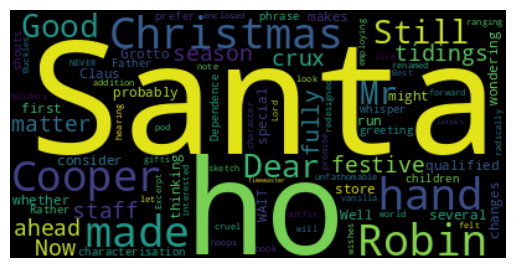

In [82]:
word_cloud = WordCloud().generate(email_body)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [83]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/jleitao/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     /home/jleitao/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

In [84]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [85]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [86]:
word_list = [''.join(word) for word in example_corpus]

In [87]:
word_list


['[',
 'Moby',
 'Dick',
 'by',
 'Herman',
 'Melville',
 '1851',
 ']',
 'ETYMOLOGY',
 '.',
 '(',
 'Supplied',
 'by',
 'a',
 'Late',
 'Consumptive',
 'Usher',
 'to',
 'a',
 'Grammar',
 'School',
 ')',
 'The',
 'pale',
 'Usher',
 '--',
 'threadbare',
 'in',
 'coat',
 ',',
 'heart',
 ',',
 'body',
 ',',
 'and',
 'brain',
 ';',
 'I',
 'see',
 'him',
 'now',
 '.',
 'He',
 'was',
 'ever',
 'dusting',
 'his',
 'old',
 'lexicons',
 'and',
 'grammars',
 ',',
 'with',
 'a',
 'queer',
 'handkerchief',
 ',',
 'mockingly',
 'embellished',
 'with',
 'all',
 'the',
 'gay',
 'flags',
 'of',
 'all',
 'the',
 'known',
 'nations',
 'of',
 'the',
 'world',
 '.',
 'He',
 'loved',
 'to',
 'dust',
 'his',
 'old',
 'grammars',
 ';',
 'it',
 'somehow',
 'mildly',
 'reminded',
 'him',
 'of',
 'his',
 'mortality',
 '.',
 '"',
 'While',
 'you',
 'take',
 'in',
 'hand',
 'to',
 'school',
 'others',
 ',',
 'and',
 'to',
 'teach',
 'them',
 'by',
 'what',
 'name',
 'a',
 'whale',
 '-',
 'fish',
 'is',
 'to',
 'be',
 

In [88]:
novel_as_string = ' '.join(word_list)

In [89]:
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

In [90]:
len(novel_as_string)

1259862

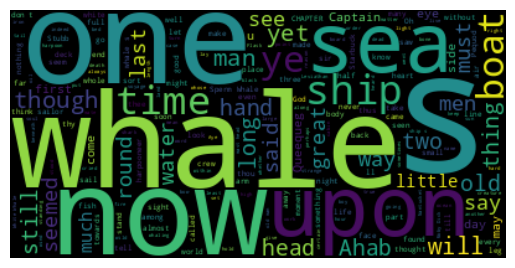

In [91]:
word_cloud = WordCloud().generate(novel_as_string)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

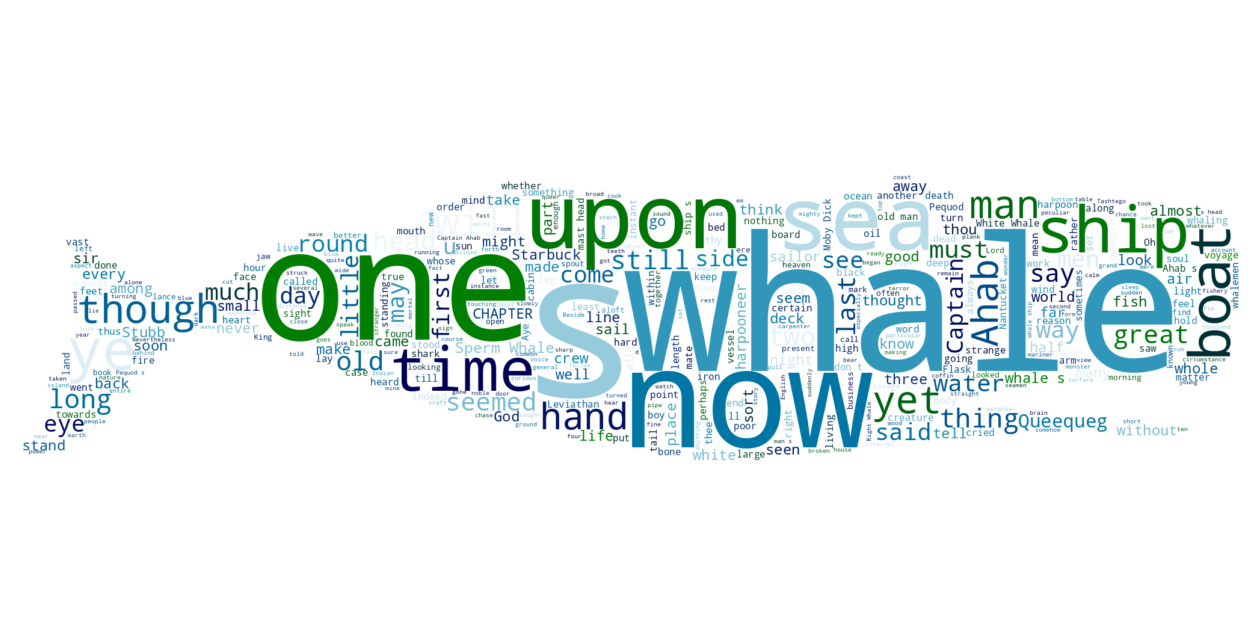

In [92]:
# Create a mask of whale
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 2555))
image_mask.paste(icon, box=icon)

# convert the image object to an array
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=400, colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [93]:
# Chalenge: use the sull image in the lesson resources to create a word clouud
# for Shakespeare's play Hamlet

# Solving the chalenge

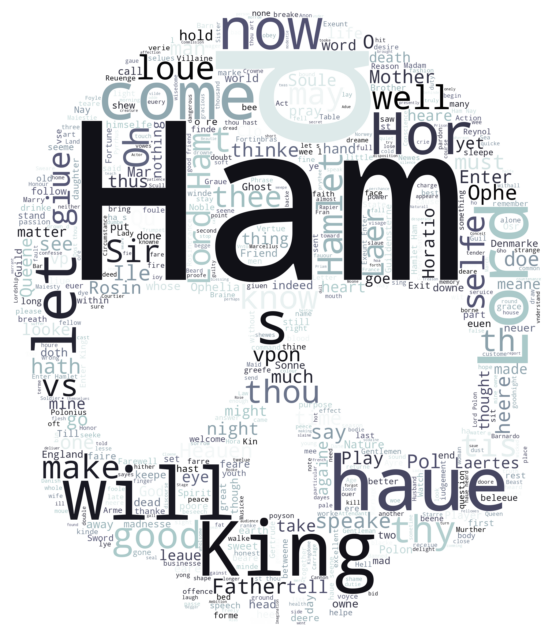

In [101]:
hamlet_txt = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_txt]
hamlet_as_string = ' '.join(word_list)

# Create a mask of skull
icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 2555))
image_mask.paste(icon, box=icon)

# convert the image object to an array
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=600, colormap='bone')
word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()